In [1]:
# Importing dependencies
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
# Is gpu available?
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(device)

cuda:0


In [3]:
# getting dataset ready...
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import os
root_dir = "data/"
batch_size=16

try:
    os.mkdir(root_dir)
except FileExistsError:
    print("Path already exist")

# Transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (1,1,1))]) #mean=0, stddev=1

# Loading data
train_data = MNIST(root=root_dir, train=True, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

classes = [str(i) for i in range(10)]

print("Num Samples:", len(train_data))

print("Image shape:", iter(train_loader).next()[0].shape)

Path already exist
Num Samples: 60000
Image shape: torch.Size([16, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


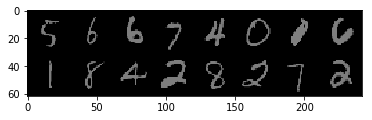

['5', '6', '6', '7', '4', '0', '0', '6', '1', '8', '4', '2', '8', '2', '7', '2']


In [4]:
# showing samples...
def get_random_sample():
    data_iter = iter(train_loader)
    for i in range(np.random.randint(100)):
        next(data_iter)
    return next(data_iter)

def show_images(images, mean=0.5, stddev=1.0):
    # de-normalizing images
    images = images*stddev + mean
    img = np.array(images.tolist())
    # making numpy compatible image
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.show()

images, lables = get_random_sample()
show_images(torchvision.utils.make_grid(images), mean=0, stddev=1)
print(list(classes[i] for i in lables))

In [5]:
# Plotting Losses
def plot_losses(stats):
    D_loss = stats["D_loss"]
    G_loss = stats["G_loss"]
    epochs = list(range(1, len(D_loss)+1))
    plt.plot(epochs, D_loss)
    plt.plot(epochs, G_loss)

In [6]:
# Defining models...

# Importing modules
import torch.nn as nn
from torch.nn.functional import relu, leaky_relu
from torch import tanh, sigmoid

# Discriminator...
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,1024)
        #self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024,128)
        #self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128,1)
        
    def forward(self,x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = leaky_relu(x, 0.2)
        #x = self.bn1(x)
        x = self.fc2(x)
        x = leaky_relu(x, 0.2)
        #x = self.bn2(x)
        x = self.fc3(x)
        x = sigmoid(x)
        return x
    
    
# Generator...
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(128,1024)
        #self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024,784)
             
    def forward(self,x):
        x = self.fc1(x)
        x = leaky_relu(x, 0.2)
        #x = self.bn1(x)
        x = self.fc2(x)        
        x = tanh(x) 
        x = x.view(-1,1,28,28)
        return x 

In [7]:
# Initializing Descriminator and Generator...
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=128, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=784, bias=True)
)


In [8]:
# Generate noise for Genarator
torch.manual_seed(123)
def generate_noise(batch_size):
    return torch.randn(batch_size, 128)

In [9]:
# Loss and Optimizer
from torch.optim import Adam

Loss = nn.MSELoss()
D_opt = Adam(D.parameters(), lr=1e-5)
G_opt = Adam(G.parameters(), lr=1e-5)

# 1-Real 0-Fake
# Noisy lables for Discriminator
def D_get_lables():
    if np.random.randint(0,9)==9:
        D_lables_real = torch.zeros(batch_size, 1).to(device)
        D_lables_fake = torch.ones(batch_size, 1).to(device)
    else:
        D_lables_real = torch.ones(batch_size, 1).to(device)
        D_lables_fake = torch.zeros(batch_size, 1).to(device)
    return D_lables_real, D_lables_fake

Epoch 1: D_loss: 0.3630660997162263 G_loss: 0.3607132757107417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


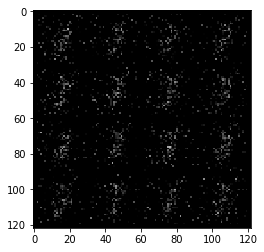

Epoch 2: D_loss: 0.1646088321345548 G_loss: 0.5819377237478892


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


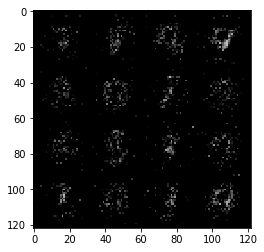

Epoch 3: D_loss: 0.23412483296742043 G_loss: 0.5588934568484625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


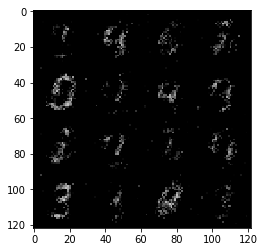

Epoch 4: D_loss: 0.2669830768217643 G_loss: 0.5391975232680639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


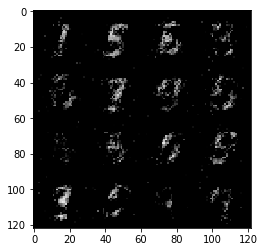

Epoch 5: D_loss: 0.23462207241455713 G_loss: 0.5750766641775767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


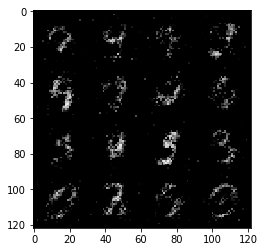

Epoch 6: D_loss: 0.23530801435212295 G_loss: 0.5779779397567113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


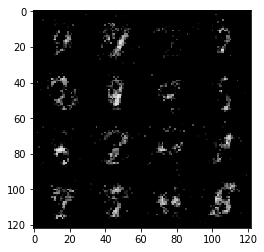

Epoch 7: D_loss: 0.26465557712465526 G_loss: 0.56331298280557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


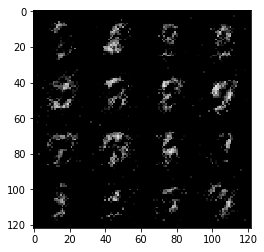

In [ ]:
# Training the networks
import time
num_epochs = 100
num_batches = len(train_loader)

stats = {"D_loss":[], "G_loss":[]}

for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    for i, data in enumerate(train_loader):
        
        # Training Discriminator
        D_opt.zero_grad()
        
        real_images, _ = data
        real_images = real_images.to(device)
        D_real = D(real_images).to(device)
        
        noise = generate_noise(batch_size).to(device)
        fake_images = G(noise).to(device)
        D_fake = D(fake_images).to(device)
        
        lables_real, lables_fake = D_get_lables()
        D_loss_real = Loss(D_real, lables_real).to(device)
        D_loss_fake = Loss(D_fake, lables_fake).to(device)
        D_loss_real.backward()
        D_loss_fake.backward()
        D_opt.step()
        
        D_running_loss += D_loss_real.item() + D_loss_fake.item()
        
        # Training Generator
        G_opt.zero_grad()
        
        noise = generate_noise(batch_size).to(device)
        fake_images = G(noise).to(device)
        D_fake = D(fake_images).to(device)
        
        # Lable smoothing for Generator
        lables_real = torch.randint(70,130,(16,1)).to(device)/100
        G_loss = Loss(D_fake, lables_real).to(device)
        G_loss.backward()
        G_opt.step()
        
        G_running_loss += G_loss.item()
        
    # Showing Generated images
    print("Epoch {}: D_loss: {} G_loss: {}".format(epoch+1, D_running_loss/num_batches, G_running_loss/num_batches))
    show_images(torchvision.utils.make_grid(fake_images, nrow=4), mean=0, stddev=1)
    
    # Updating stats
    stats["D_loss"].append(D_running_loss/num_batches)
    stats["G_loss"].append(G_running_loss/num_batches)
    
plot_losses(stats)    